## Data pre-processing

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

In [135]:
df = pd.read_json('transactions.json',lines=True,orient='records')

In [136]:
# Replacing null values with NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

In [137]:
# Dropping with features with zero entries
df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd'],
                  axis=1,inplace=True)

In [138]:
df['matchingCVV'] = df['cardCVV'] == df['enteredCVV']

In [139]:
# Dropping features which have no importance in modelling
df.drop(['customerId','accountNumber','merchantName','currentExpDate','transactionDateTime','accountOpenDate','dateOfLastAddressChange','cardCVV','enteredCVV','cardLast4Digits','transactionDateTime'],
                  axis=1,inplace=True)

In [140]:
df.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,matchingCVV
0,5000,5000.0,98.55,US,US,02,01,rideshare,PURCHASE,0.0,False,False,False,True
1,5000,5000.0,74.51,US,US,09,01,entertainment,PURCHASE,0.0,True,False,False,True
2,5000,5000.0,7.47,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True
3,5000,5000.0,7.47,US,US,09,01,mobileapps,PURCHASE,0.0,False,False,False,True
4,5000,5000.0,71.18,US,US,02,01,fastfood,PURCHASE,0.0,True,False,False,True


In [141]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler

### Under-sampling

#### Applying under-sampling as the input to output data is imbalanced. Keeping the ratio of fradulent to non-fradulent cases as 0.2

In [142]:
ros = RandomUnderSampler(sampling_strategy=0.2,random_state=42)
y_raw = df['isFraud']
df.drop('isFraud', inplace=True, axis=1)
new_x, new_y = ros.fit_resample(df, y_raw)
print(f'Before Random Under Sampling: {df.shape}')
print(f'After Random Under Sampling: {new_x.shape}')

Before Random Under Sampling: (786363, 13)
After Random Under Sampling: (74502, 13)


In [143]:
new_x.head()

,creditLimit,availableMoney,transactionAmount,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,matchingCVV
0,2500,2500.00,222.61,US,US,02,01,food,PURCHASE,0.00,True,False,True
1,50000,49904.26,63.18,US,US,02,01,subscriptions,PURCHASE,95.74,False,False,True
2,7500,3147.92,57.83,US,US,09,01,health,PURCHASE,4352.08,False,False,True
3,10000,3403.54,34.41,US,US,05,01,rideshare,PURCHASE,6596.46,False,False,True
4,7500,1760.22,396.22,US,US,05,01,fastfood,PURCHASE,5739.78,True,False,True


In [144]:
new_y.head()

0    False
1    False
2    False
3    False
4    False
Name: isFraud, dtype: bool

In [145]:
new_y.value_counts()

False    62085
True     12417
Name: isFraud, dtype: int64

### Encoding categorical data

In [146]:
categorical_cols =  ['creditLimit',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch',
 'matchingCVV']

Xe = pd.get_dummies(new_x, columns = categorical_cols)

In [147]:
Xe.head()

,availableMoney,transactionAmount,currentBalance,creditLimit_250,creditLimit_500,creditLimit_1000,creditLimit_2500,creditLimit_5000,creditLimit_7500,creditLimit_10000,...,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_False,cardPresent_True,expirationDateKeyInMatch_False,expirationDateKeyInMatch_True,matchingCVV_False,matchingCVV_True
0,2500.00,222.61,0.00,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,49904.26,63.18,95.74,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,0,1
2,3147.92,57.83,4352.08,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
3,3403.54,34.41,6596.46,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,0,1
4,1760.22,396.22,5739.78,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1


In [148]:
categorical_cols =  ['creditLimit',
 'acqCountry',
 'merchantCountryCode',
 'posEntryMode',
 'posConditionCode',
 'merchantCategoryCode',
 'transactionType',
 'cardPresent',
 'expirationDateKeyInMatch',
 'matchingCVV']

Xe = pd.get_dummies(new_x, columns = categorical_cols)

In [149]:
Xe.head()

,availableMoney,transactionAmount,currentBalance,creditLimit_250,creditLimit_500,creditLimit_1000,creditLimit_2500,creditLimit_5000,creditLimit_7500,creditLimit_10000,...,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_False,cardPresent_True,expirationDateKeyInMatch_False,expirationDateKeyInMatch_True,matchingCVV_False,matchingCVV_True
0,2500.00,222.61,0.00,0,0,0,1,0,0,0,...,0,0,1,0,0,1,1,0,0,1
1,49904.26,63.18,95.74,0,0,0,0,0,0,0,...,1,0,1,0,1,0,1,0,0,1
2,3147.92,57.83,4352.08,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
3,3403.54,34.41,6596.46,0,0,0,0,0,0,1,...,0,0,1,0,1,0,1,0,0,1
4,1760.22,396.22,5739.78,0,0,0,0,0,1,0,...,0,0,1,0,0,1,1,0,0,1


In [150]:
# Encoding the Dependent Variable
le = LabelEncoder()
ye = le.fit_transform(new_y)

In [151]:
ye = pd.DataFrame(ye,columns=['IsFraud'])
ye.head()

,IsFraud
0,0
1,0
2,0
3,0
4,0


### Splitting data into training and test set

#### Splitting the training and test data with a ratio of 80:20 %

In [152]:
# Splitting into training and test set
X_train, X_test, y_train, y_test = train_test_split(Xe, ye, test_size =
0.2, random_state = 1)

In [154]:
# Standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train.iloc[:, :3] = sc.fit_transform(X_train.iloc[:, :3])
X_test.iloc[:, :3] = sc.transform(X_test.iloc[:, :3])

In [158]:
X_train.head()

,availableMoney,transactionAmount,currentBalance,creditLimit_250,creditLimit_500,creditLimit_1000,creditLimit_2500,creditLimit_5000,creditLimit_7500,creditLimit_10000,...,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_False,cardPresent_True,expirationDateKeyInMatch_False,expirationDateKeyInMatch_True,matchingCVV_False,matchingCVV_True
18657,0.340986,-0.376236,0.177779,0,0,0,0,0,0,0,...,1,0,1,0,0,1,1,0,0,1
73224,-0.304115,0.825270,1.047963,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
47387,0.986453,-0.877938,-0.692898,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
5112,-0.679074,0.569646,-0.689766,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
34463,0.019494,-0.920858,0.611444,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1


In [157]:
X_test.head()

,availableMoney,transactionAmount,currentBalance,creditLimit_250,creditLimit_500,creditLimit_1000,creditLimit_2500,creditLimit_5000,creditLimit_7500,creditLimit_10000,...,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_PURCHASE,transactionType_REVERSAL,cardPresent_False,cardPresent_True,expirationDateKeyInMatch_False,expirationDateKeyInMatch_True,matchingCVV_False,matchingCVV_True
42020,14829.92,183.97,170.08,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1
31271,1389.16,149.31,6110.84,0,0,0,0,0,1,0,...,0,0,1,0,1,0,1,0,0,1
59464,42102.75,20.62,7897.25,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
29610,6419.03,114.29,43580.97,0,0,0,0,0,0,0,...,0,0,1,0,0,1,1,0,0,1
5947,1265.69,216.32,3734.31,0,0,0,0,1,0,0,...,0,0,1,0,0,1,1,0,0,1


## Logistic Regression

In [209]:
from sklearn.linear_model import LogisticRegression

In [210]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [211]:
preds = classifier.predict(X_test)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

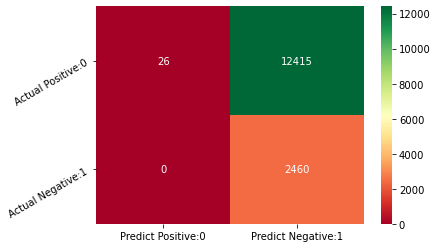

In [212]:
# visualize confusion matrix with seaborn heatmap
CM=confusion_matrix(y_test, preds)

cm_matrix = pd.DataFrame(data=CM, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [213]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))

Accuracy: 0.6936


In [214]:
#Precision score on the test data
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix
print("Precision Score:",round(precision_score(y_test, y_pred),4))

Precision Score: 0.2612


In [215]:
#check precision rate score on validation data
print("F-1 Score:",round(f1_score(y_test, y_pred),4)) 

F-1 Score: 0.3352


## Random Forest classifier

In [175]:
from sklearn.ensemble import RandomForestClassifier

In [188]:
classifier = RandomForestClassifier(n_estimators = 10, criterion ='entropy', random_state = 0)

In [189]:
classifier.fit(X_train, y_train)

<ipython-input-189-f44724590846>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

In [190]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

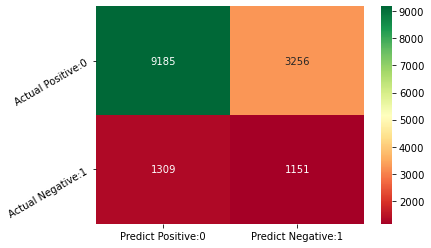

In [191]:
# visualize confusion matrix with seaborn heatmap
CM=confusion_matrix(y_test, y_pred)

cm_matrix = pd.DataFrame(data=CM, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [192]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",round(accuracy_score(y_test, y_pred),4))

Accuracy: 0.6936


In [193]:
# Precision score on the test data
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix
print("Precision Score:",round(precision_score(y_test, y_pred),4))

Precision Score: 0.2612


In [172]:
#check precision rate score on validation data
print("F-1 Score:",round(f1_score(y_test, y_pred),4)) 

F-1 Score: 0.3352


In [227]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(18,9))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + " " +'Feature Importance',weight='bold')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

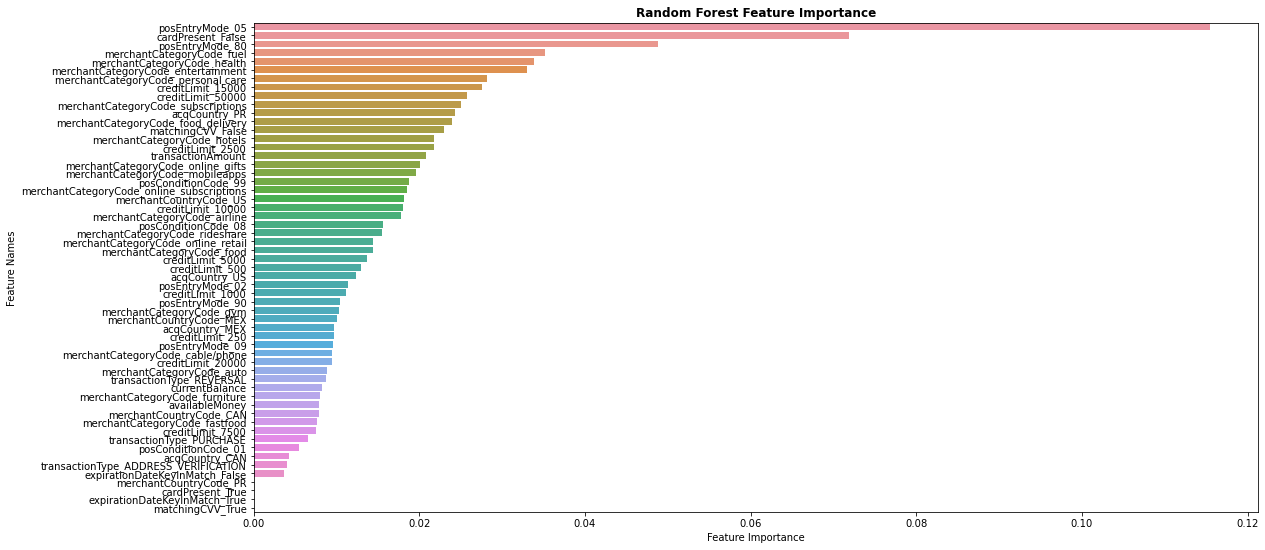

In [228]:
plot_feature_importance(classifier.feature_importances_,X_train.columns,'Random Forest')

## Gradient Boosting

In [198]:
from sklearn.ensemble import GradientBoostingCla1ssifier

ImportError: cannot import name 'GradientBoostingCla1ssifier' from 'sklearn.ensemble' (C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\__init__.py)

In [199]:
clf = GradientBoostingClassifier(n_estimators=100, 
                                 learning_rate=0.1,
                                 max_depth=3, 
                                 random_state=5).fit(X_train, y_train)

C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [200]:
predictions = clf.predict(X_test)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

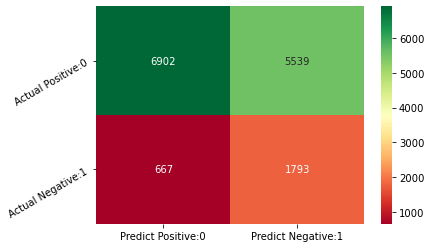

In [202]:
# visualize confusion matrix with seaborn heatmap
CM_grb=confusion_matrix(y_test, predictions)

cm_matr = pd.DataFrame(data=CM_grb, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matr, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [204]:
# Model Accuracy
print("Accuracy:",round(accuracy_score(y_test, predictions),4))

Accuracy: 0.5835


In [207]:
# Precision Score on the test data
print("Precision Score:",round(precision_score(y_test, predictions),4))

Precision Score: 0.2445


In [208]:
# Precision Score on the test data
print("F-1 Score:",round(f1_score(y_test, predictions),4))

F-1 Score: 0.3662


## XGBoost

In [218]:
from xgboost import XGBClassifier
classifier = XGBClassifier()
classifier.fit(X_train, y_train)

C:\Users\niraj\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\niraj\AppData\Roaming\Python\Python38\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = 

[06:58:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [219]:
xg_pred = classifier.predict(X_test)

(array([0.5, 1.5]), <a list of 2 Text major ticklabel objects>)

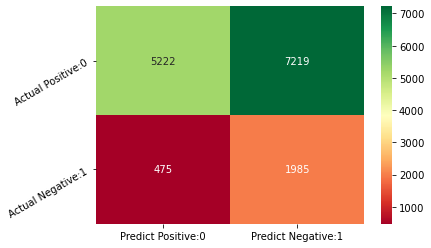

In [220]:
# visualize confusion matrix with seaborn heatmap
CM_grb=confusion_matrix(y_test, xg_pred)

cm_matr = pd.DataFrame(data=CM_grb, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matr, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [221]:
# Model Accuracy
print("Accuracy:",round(accuracy_score(y_test, predictions),4))

Accuracy: 0.5835


In [222]:
# Precision Score on the test data
print("Precision Score:",round(precision_score(y_test, predictions),4))

Precision Score: 0.2445


In [223]:
# Precision Score on the test data
print("F-1 Score:",round(f1_score(y_test, predictions),4))

F-1 Score: 0.3662


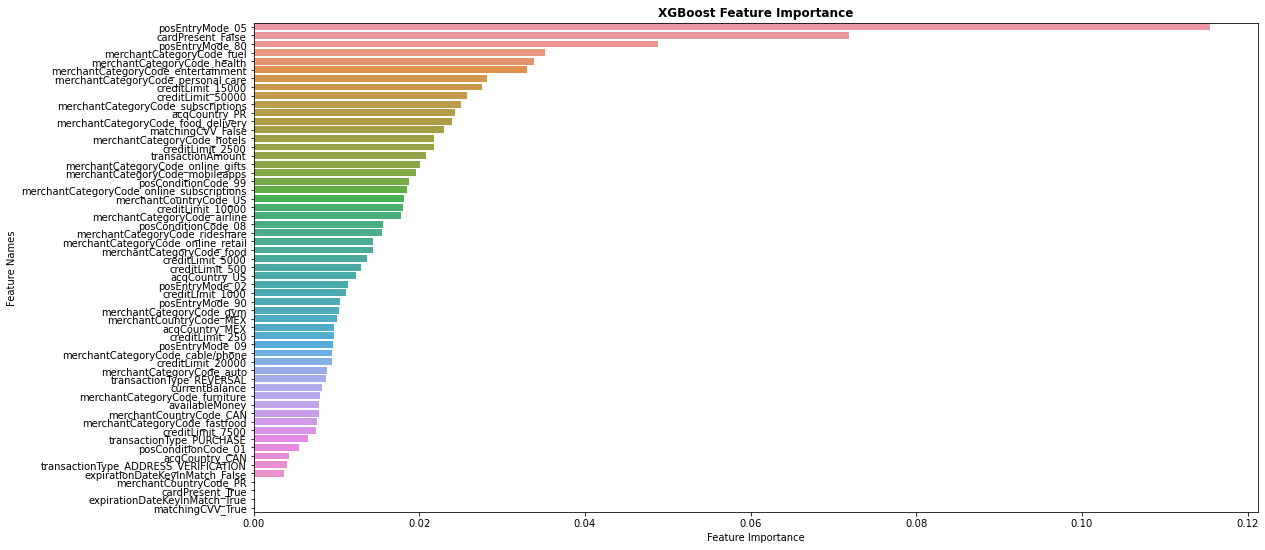

In [224]:
plot_feature_importance(classifier.feature_importances_,X_train.columns,'XGBoost')